# Global definitions

Load Pylab, define CPTs...

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Define the CPTs

In [2]:
L = array([0.9, 0.1])

B = array([0.99, 0.01])

P_L = array([[0.8, 0.1], 
             [0.2, 0.9]])

T_P = array([[0.8, 0.1], 
             [0.2, 0.9]])

O_PB = array ([[[0.01, 0.7],
                [0.8, 0.999]],
               [[0.99, 0.3],
               [0.2, 0.001]]])
print L[1]

0.1


In [40]:
# Define the CPTs and other useful functions here (e.g. samling from a distribution) here...

def sampleL_TO(n):
    samples = []
    for i in range(0, n):
        samples.append([random.random(), random.randint(0, 2), random.randint(0, 2)])
    return np.asmatrix(samples)
        
def sample(n):
    return random.sample(n)

print sample(2)

[ 0.35891418  0.44611201]


# 1) Approximate Inference Algorithms

Approximate $P(E\mid M, S)$ using various techniques.

## A) Rejection Sampling

In [48]:
#global L_TO_rs
def approx_rs(t, o, n):
    
    """ 
    Approximates P(L | T, O) using rejection sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    
    """
    First generate the random samples for the events
    An array of triples was used for taking into consideration only the variables that are of interested for the given problem
    """
    L_TO = sampleL_TO(n)
    """
    Discover how many events fulfill the conditions t and o (the evidence)
    If there are events that fulfill the evidence, check how many of them verify L = l 
    If no event fulfills the evidence repeat sampling procedure
    """
  
    consistentEv = L_TO[(L_TO[:,1] == t) & (L_TO[:,2] == o)][0,:]
    if consistentEv.size != 0:
        pos_samples = array(consistentEv[consistentEv > L[0]]).size
        RS_Approx_L_TO = array([1 - double(pos_samples)/consistentEv.size, double(pos_samples)/consistentEv.size])
    else:
        approx_rs(t, o, n)    
    
    return RS_Approx_L_TO


L_TO_rs = approx_rs(1, 0, 10000)
print L_TO_rs

## B) Likelihood Weighting

In [50]:
global L_TO_lw
global valid_weight
global total_weight
def approx_lw(t, o, n):
    """
    Empty implementation of Aiv)
    Approximates P(L | T, O) using likelihood weighting
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    valid_weight = 0
    total_weight = 0
    """
    Chosen topological ordering: L, P, B O, T
    """
    
    
    """
    Sample L, P, B
    """
    s_L = sample(n)
    s_P = sample(n) 
    s_B = sample(n)
    """
    O and T are given as parameters
    """
    for i in range (0, n):
        weight = 1
        if (s_L[i]>L[0]):
            if (s_P[i]>P_L[0, 1]):
                if (t == 1):
                    weight *= T_P[1, 1]
                else:
                    weight *= T_P[0, 1]
                if (s_B[i]>B[0]):
                    if (o == 1):
                        weight *= O_PB[1, 1, 1]
                    else: 
                        weight *= O_PB[0, 1, 1]
                else:
                    if (o == 1):
                        weight *= O_PB[0, 1, 0]
                    else: 
                        weight *= O_PB[1, 1, 0]
            else:
                if (t == 1):
                    weight *= T_P[1, 0]
                else:
                    weight *= T_P[0, 0]
                if (s_B[i]>B[0]):
                    if (o == 1):
                        weight *= O_PB[1, 0, 1]
                    else: 
                        weight *= O_PB[0, 0, 1]
                else:
                    if (o == 1):
                        weight *= O_PB[1, 0, 0]
                    else: 
                        weight *= O_PB[0, 0, 0]   
            valid_weight += weight
        else:
            if (s_P[i]>P_L[0, 0]):
                if (t == 1):
                    weight *= T_P[0, 1]
                else:
                    weight *= T_P[0, 0]
                if (s_B[i]>B[0]):
                    if (o == 1):
                        weight *= O_PB[1, 1, 1]
                    else: 
                        weight *= O_PB[0, 1, 1]
                else:
                    if (o == 1):
                        weight *= O_PB[0, 1, 0]
                    else: 
                        weight *= O_PB[1, 1, 0]
            else:
                if (t == 1):
                    weight *= T_P[1, 0]
                else:
                    weight *= T_P[0, 0]
                if (s_B[i]>B[0]):
                    if (o == 1):
                        weight *= O_PB[1, 0, 1]
                    else: 
                        weight *= O_PB[0, 0, 1]
                else:
                    if (o == 1):
                        weight *= O_PB[1, 0, 0]
                    else: 
                        weight *= O_PB[0, 0, 0] 
        total_weight += weight
    LW_Approx_L_TO = [1-double(valid_weight)/total_weight, double(valid_weight)/total_weight]
    return LW_Approx_L_TO


L_TO_lw = approx_lw(1, 0, 10000)
print L_TO_lw

[0.27080133532518003, 0.72919866467481997]


## C) Gibbs Sampling

In [6]:
def approx_gibbs(t, o, n):
    
    """ 
    Approximates P(L | T, O) using Gibbs sampling
    :param t: given value for T
    :param o: given value for O
    :param n: number of samples to use
    :returns: Numpy array containing the approximated distribution
    """
    
    # TODO: implement this function
    return array([0, 0])

# 2) Comparison

## A) Exact Inference

In [7]:
def exact(t, o):
    """ 
    Computes P(L | T, O) using exact inference
    :param t: given value for T
    :param o: given value for O
    :returns: Numpy array containing the distribution
    """
    # TODO: implement this function
    # t = 1; o = 1
    col_b = 0
    
    
    L_OT = L[1] * (P_L[0, 1] * T_P[t, 0] * B[0] * O_PB[o, 0, 0] + # p = 0, b = 0 
                 + P_L[0, 1] * T_P[t, 0] * B[1] * O_PB[o, 0, 1] + # p = 0, b = 1
                 + P_L[1, 1] * T_P[t, 1] * B[0] * O_PB[o, 1, 0] + # p = 1, b = 0 
                 + P_L[1, 1] * T_P[t, 1] * B[1] * O_PB[o, 1, 1]) # p = 1, b = 1
    NL_OT = L[0] *(P_L[0, 0] * T_P[t, 0] * B[0] * O_PB[o, 0, 0] + # p = 0, b = 0 
                 + P_L[0, 0] * T_P[t, 0] * B[1] * O_PB[o, 0, 1] + # p = 0, b = 1
                 + P_L[1, 0] * T_P[t, 1] * B[0] * O_PB[o, 1, 0] + # p = 1, b = 0 
                 + P_L[1, 0] * T_P[t, 1] * B[1] * O_PB[o, 1, 1]) # p = 1, b = 1
    
    Lsum = L_OT + NL_OT
    
    return array([double(NL_OT)/Lsum, double(L_OT)/Lsum])
exact(1, 0)

array([ 0.67066293,  0.32933707])

## B) Compute and plot estimation errors

In [8]:
def kld(p, q):
    """
    Computes the Kullback-Leibler divergence between p and q.
    :param p: true distribution
    :param q: estimated distribution
    :return: Kullback-Leibler Divergence between p and q
    """
    return (p * np.log(p / (q + 0.00000000001))).sum()  # add a small constant for numeric stability


def compute_approximation_error(approx_function, t, o, n_runs, sample_counts, **kwargs):
    """
    Computes the approximation error for a given approximation method.
    :param approx_function: function used to approximate the distribution
    :param t: given value for T
    :param o: given value for O
    :param n_runs: number of approximations
    :param sample_counts: list or array of numbers of sampels to use
    :returns: mean approximation error for each of the sample counts
    """
    mean_errors = []
    correct = exact(t, o)
    
    for num_samples in sample_counts:
        estimates = array([approx_function(t, o, n=num_samples, **kwargs) for i in range(n_runs)])
        mean_errors.append(abs(estimates - correct).mean())       
        #mean_errors.append(kld(correct, estimates))  # use this instead of the line above for KLD!
    
    return mean_errors

### Compute the estimation errors


In [49]:
rs_errs = {}
lw_errs = {}
gb_errs = {}
n_runs = 100
sample_counts = array([10, 20, 40, 80, 160, 320, 640, 1280])

for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    rs_errs[(t, o)] = compute_approximation_error(approx_rs, t, o, n_runs, sample_counts)
    lw_errs[(t, o)] = compute_approximation_error(approx_lw, t, o, n_runs, sample_counts)
    gb_errs[(t, o)] = compute_approximation_error(approx_gibbs, t, o, n_runs, sample_counts)

UnboundLocalError: local variable 'RS_Approx_L_TO' referenced before assignment

### Plot the estimation errors

NameError: name 'sample_counts' is not defined

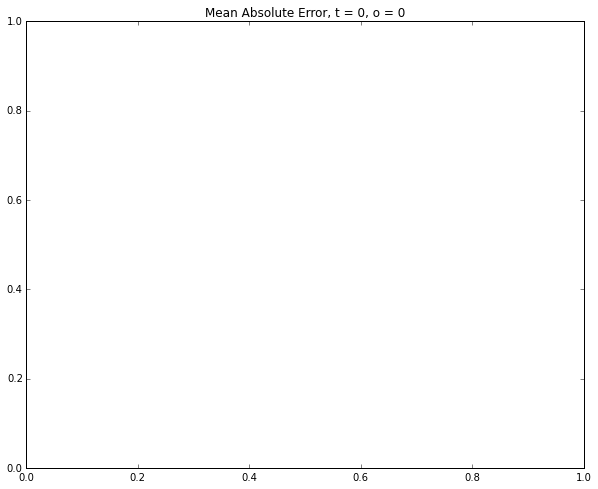

In [213]:
for t, o in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    figure(figsize=(10, 8))
    title('Mean Absolute Error, t = %d, o = %d' % (t, o))

    plot(sample_counts, rs_errs[(t, o)], 'r', label='Rejection Sampling', lw=2)
    plot(sample_counts, lw_errs[(t, o)], 'g', label='Likelihood Weighting', lw=2)
    plot(sample_counts, gb_errs[(t, o)], 'b', label='Gibbs Sampling', lw=2)   
    
    legend()
    xscale('log')
    xlim(sample_counts.min(), sample_counts.max())
    xlabel('Number of samples')